In [ ]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from PIL import Image

drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/Poisson_Study/data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import cv2
import glob
import tensorflow as tf
from skimage.io import imread
from skimage.transform import radon, iradon, rescale
from sklearn.model_selection import train_test_split
from os.path import basename
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/Poisson_Study/labels.csv")

# Define the custom blocks for the VGG-like model
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions
        self.conv_layers = [
            tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding="same")
            for _ in range(repetitions)
        ]
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size, strides=strides)

    def call(self, inputs):
        x = inputs
        for conv in self.conv_layers:
            x = conv(x)
        return self.max_pool(x)

class MyVGG(tf.keras.Model):
    def __init__(self, num_classes):
        super(MyVGG, self).__init__()
        self.block_a = Block(filters=64, kernel_size=3, repetitions=2)
        self.block_b = Block(filters=128, kernel_size=3, repetitions=2)
        self.block_c = Block(filters=256, kernel_size=3, repetitions=3)
        self.block_d = Block(filters=512, kernel_size=3, repetitions=3)
        self.block_e = Block(filters=512, kernel_size=3, repetitions=3)
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(256, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten(x)
        x = self.fc(x)
        return self.classifier(x)

def prepare_images(file_paths, image_size=(256, 256), theta=np.linspace(0., 180., 180, endpoint=False)):
    img_array = []
    labels = []
    for file_path in file_paths:
        img = imread(file_path, as_gray=True)
        if img is None:
            print("Failed to load image:", file_path)
            continue

        img = rescale(img, scale=0.4, mode='reflect', multichannel=False, anti_aliasing=False)
        sinogram = radon(img, theta=theta)

        scale_factor = 1.5  # Adjust this factor based on your application
        noisy_sinogram = np.random.poisson(sinogram * scale_factor)

        reconstructed_image = iradon(noisy_sinogram, theta=theta, filter_name='hamming')
        reconstructed_image = cv2.resize(reconstructed_image, image_size)

        reconstructed_image = np.expand_dims(reconstructed_image, axis=-1) / 255.0
        img_array.append(reconstructed_image)

        base_name = basename(file_path)
        label_series = df[df['filename'] == base_name]['hemorrhage']
        if not label_series.empty:
            labels.append(label_series.iloc[0])
        else:
            print(f"No label found for {base_name}; skipping image.")

    return np.array(img_array), np.array(labels)

file_paths = glob.glob("/content/drive/My Drive/Poisson_Study/data/*.png")

X, y = prepare_images(file_paths)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = MyVGG(num_classes=2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))


In [ ]:
import tensorflow as tf

model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

print(model.summary())


553467096/553467096 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
def generate_saliency_map(model, image):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)[tf.newaxis, ...]  # Add batch dimension
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        top_prediction = predictions[:, tf.argmax(predictions, axis=1)[0]]
    grads = tape.gradient(top_prediction, image_tensor)
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))
    saliency_map = tf.image.resize(saliency_map, image.shape[:2])
    return saliency_map

image_index = 0
input_image = X_test[image_index]

saliency_map = generate_saliency_map(model, input_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(input_image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Saliency Map')
plt.imshow(saliency_map, cmap='hot')
plt.axis('off')

plt.show()


1/1 [==============================] - 1s 842ms/step


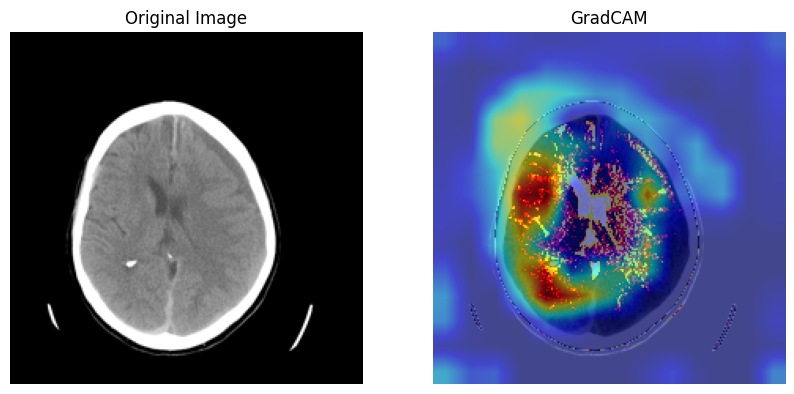

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import cv2

model = VGG16(weights='imagenet')

last_conv_layer_name = 'block5_conv3'

last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

img_path = '/content/drive/MyDrive/Poisson_Study/data_large/ID_046070162.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

last_conv_layer_output = last_conv_layer_model.predict(img_array)

preds = model.predict(img_array)
top_pred_index = np.argmax(preds[0])

cam_model = Model(inputs=model.inputs, outputs=(last_conv_layer.output, model.output))
with tf.GradientTape() as tape:
    last_conv_output, preds = cam_model(img_array)
    class_output = preds[:, top_pred_index]

grads = tape.gradient(class_output, last_conv_output)

grad_cam = tf.reduce_mean(grads[0], axis=(0, 1))
cam = tf.matmul(last_conv_output[0], grad_cam[..., tf.newaxis])
cam = tf.squeeze(cam)

cam = tf.nn.relu(cam).numpy()

cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

img_rgb = cv2.cvtColor(img_array[0], cv2.COLOR_BGR2RGB)

superimposed_img = cv2.addWeighted(img_rgb.astype('uint8'), 0.5, heatmap.astype('uint8'), 0.5, 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('GradCAM')
plt.axis('off')

plt.show()
